In [123]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [124]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [28]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

Plots.PyPlotBackend()

We are interested in simulating the Lorenz attractor
            $$ ẋ = \sigma(y - x)\\
       ẏ = x(\rho-z) - y\\
       ż = xy - \beta z$$

Define parameters of the Lorenz attractor

In [29]:
function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end


u0 = [10.0; -5.0; 2.0]
tspan = (0.0,40.0)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]

prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob, RK4(), adaptive = false, dt = Δt)

integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 3-element Array{Float64,1}:
 10.0
 -5.0
  2.0

In [30]:
states = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [10.0, -5.0, 2.0]

In [31]:
for t in T[1:end-1]
    step!(integrator)
    push!(states, deepcopy(integrator.u))
end

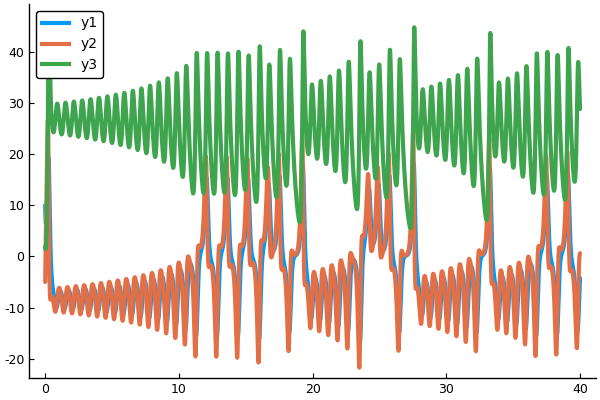

In [32]:
plot(T, hcat(states...)[1,:], linewidth  = 3)
plot!(T, hcat(states...)[2,:], linewidth = 3)
plot!(T, hcat(states...)[3,:], linewidth = 3)

Define propagation function fprop

In [33]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
        for j=1:50
        step!(integrator)
        end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [34]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [35]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return [s[1]+s[2]+s[3]]
end

In [36]:
function (::MeasurementFunction)(t::Float64) 
    return reshape([1.0, 1.0 , 1.0],(1,3))
end

In [37]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z, always measure the true state but is corrupted by noise ϵ

In [38]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
    fill!(ENS, [deepcopy(s[1]+s[2]+s[3])])
    end
    return ENS
end

In [39]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [59]:
# A = MultiAdditiveInflation(3, 1.05, MvNormal(zeros(3), 1.0*I))
A = RTPSAdditiveInflation(0.7, MvNormal(zeros(3), 1.0*I))
# A = IdentityInflation()

RTPSAdditiveInflation(0.7, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
)

Define noise covariance

In [60]:
ϵ = AdditiveInflation(MvNormal(zeros(1), 3.0*I))

AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [9.0]
)
)

In [108]:
N = 10
NZ = 1
isinflated = true
isfiltered = false
isaugmented = false

false

In [109]:
u0

3-element Array{Float64,1}:
 10.0
 -5.0
  2.0

In [118]:
ens = initialize(N, MvNormal([20.0, -10.0, 10.0], Diagonal([1.0, 10.0, 3.0])))
estimation_state = [deepcopy(ens.S)]

tmp = deepcopy(u0)
true_state = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [10.0, -5.0, 2.0]

In [119]:
g = FilteringFunction()

FilteringFunction()

In [120]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{100000,1}(PropagationFunction(), RTPSAdditiveInflation(0.7, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [9.0]
)
), true, false, false)

In [129]:
std(ens.S, corrected = true)#-[1.0; √10; √3]

3-element Array{Float64,1}:
 1.000280334496187 
 3.1804106406588524
 1.730161289063207 

In [130]:
?mean

search: mean meandir meanlogx meanform ZeroMeanIsoNormal ZeroMeanFullNormal



```
mean(itr)
```

Compute the mean of all elements in a collection.

!!! note
    If `itr` contains `NaN` or [`missing`](@ref) values, the result is also `NaN` or `missing` (`missing` takes precedence if array contains both). Use the [`skipmissing`](@ref) function to omit `missing` entries and compute the mean of non-missing values.


# Examples

```jldoctest
julia> mean(1:20)
10.5

julia> mean([1, missing, 3])
missing

julia> mean(skipmissing([1, missing, 3]))
2.0
```

---

```
mean(f::Function, itr)
```

Apply the function `f` to each element of collection `itr` and take the mean.

```jldoctest
julia> mean(√, [1, 2, 3])
1.3820881233139908

julia> mean([√1, √2, √3])
1.3820881233139908
```

---

```
mean(A::AbstractArray; dims)
```

Compute the mean of an array over the given dimensions.

!!! compat "Julia 1.1"
    `mean` for empty arrays requires at least Julia 1.1.


# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Array{Int64,2}:
 1  2
 3  4

julia> mean(A, dims=1)
1×2 Array{Float64,2}:
 2.0  3.0

julia> mean(A, dims=2)
2×1 Array{Float64,2}:
 1.5
 3.5
```

---

```
mean(A::AbstractArray, w::AbstractWeights[, dims::Int])
```

Compute the weighted mean of array `A` with weight vector `w` (of type `AbstractWeights`). If `dim` is provided, compute the weighted mean along dimension `dims`.

# Examples

```julia
w = rand(n)
mean(x, weights(w))
```

---

```
mean(d::UnivariateDistribution)
```

Compute the expectation.

---

```
mean(d::MultivariateDistribution)
```

Compute the mean vector of distribution `d`.

---

```
mean(d::MatrixDistribution)
```

Return the mean matrix of `d`.

---

```
mean(d::Union{UnivariateMixture, MultivariateMixture})
```

Compute the overall mean (expectation).

---

```
Return the mean of all the ensemble members
```


### Ensemble Kalman filter estimation

In [68]:
Δt = 1e-2
Tsub = 0.0:50*Δt:40.0-50*Δt

@showprogress for (n,t) in enumerate(Tsub)

    global ens
#     enkf.f(t, ens)
    t, ens, _ = enkf(t, 50*Δt, ens)
    push!(estimation_state, deepcopy(ens.S))
    

end

MethodError: MethodError: no method matching iterate(::EnsembleState{10,Array{Float64,1}})
Closest candidates are:
  iterate(!Matched::Core.SimpleVector) at essentials.jl:568
  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:568
  iterate(!Matched::ExponentialBackOff) at error.jl:199
  ...

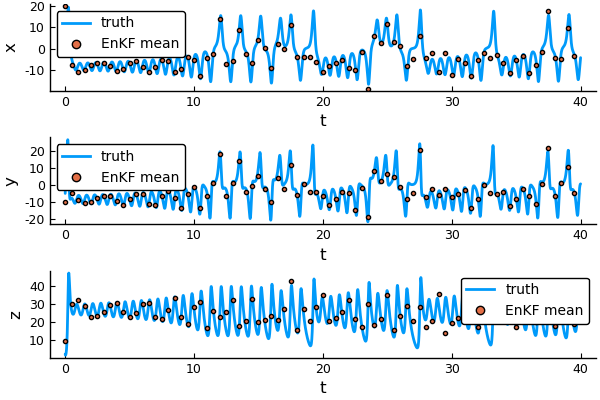

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [57]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)

plt = plot(layout = (3, 1), legend = true)
plot!(plt[1], T, s[1,1:end], linewidth = 2, label = "truth")
scatter!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

plot!(plt[2], T, s[2,1:end], linewidth = 2, label = "truth")
scatter!(plt[2], Tsub, ŝ[2,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash)

plot!(plt[3], T, s[3,1:end], linewidth = 2, label = "truth")
scatter!(plt[3], Tsub, ŝ[3,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "z", linestyle =:dash)

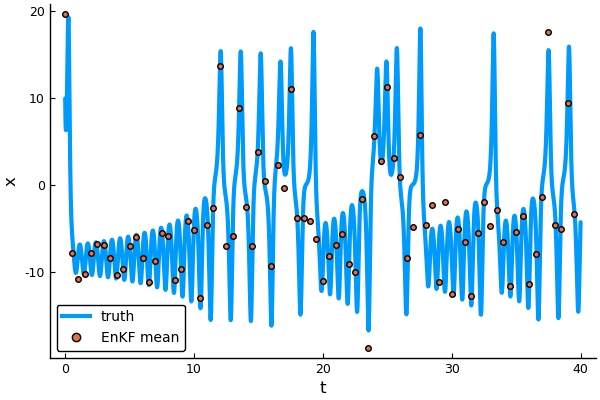

In [58]:
plot(T, s[1,:], linewidth = 3, label = "truth")
# plot!(Tsub, ŝ[1,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)
scatter!(Tsub, ŝ[1,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

In [26]:
# plot(s[1,:], s[2,:], s[3,:], linewidth = 2, label = "truth", legend = true)
# plot!(ŝ[1,1:end-1], ŝ[2,1:end-1], ŝ[3,1:end-1], linewidth = 2, label = "EnKF mean", xlabel = "x", 
#     ylabel = "y", zlabel ="z", linestyle = :solid)
# scatter!(ŝ[1,:], ŝ[2,:], ŝ[3,:], linewidth = 2, label = "EnKF mean", xlabel = "x", 
#     ylabel = "y", zlabel ="z", linestyle = :solid)